In [2]:
!pip install pmdarima
# setting logging to print only error messages from Sklearnex
import logging
logging.basicConfig()
logging.getLogger("SKLEARNEX").setLevel(logging.ERROR)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from datetime import datetime

from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error,mean_absolute_error
import math

import warnings
warnings.filterwarnings("ignore")

sns.set_theme(palette="Set2")


def get_mda(y, yhat):
    """Mean Directional Accuracy, as per:
    https://www.wikiwand.com/en/Mean_Directional_Accuracy
    """
    a = np.sign(np.diff(y))
    b = np.sign(np.diff(yhat))
    return np.sum(a == b)/a.shape[0]

In [3]:
df=pd.read_csv("MICROSOFT BP DATA.csv")

In [4]:
df.head()

,Date,Open,High,Low,Close,Volume,Day of the week,Change,NASDAQ
0,01-04-2014,41.150002,41.590000,41.070000,41.419998,32605000.0,3.0,-0.070000,3658.399902
1,02-04-2014,41.439999,41.660000,41.169998,41.349998,28666700.0,4.0,-0.340000,3665.989990
2,03-04-2014,41.290001,41.290001,40.709999,41.009998,30139600.0,5.0,-1.139999,3637.580078
3,04-04-2014,41.250000,41.389999,39.639999,39.869999,51409600.0,6.0,-0.070000,3539.379883
4,07-04-2014,39.959999,40.270000,39.740002,39.799999,37559600.0,2.0,0.020001,3507.750000


In [5]:
df = df.iloc[:-62, :]

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2205 entries, 0 to 2204
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             2205 non-null   object 
 1   Open             2205 non-null   float64
 2   High             2205 non-null   float64
 3   Low              2205 non-null   float64
 4   Close            2205 non-null   float64
 5   Volume           2205 non-null   float64
 6   Day of the week  2205 non-null   float64
 7   Change           2205 non-null   float64
 8   NASDAQ           2205 non-null   float64
dtypes: float64(8), object(1)
memory usage: 155.2+ KB


## Convert the "time" column to the datetime type

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2205 entries, 0 to 2204
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             2205 non-null   object 
 1   Open             2205 non-null   float64
 2   High             2205 non-null   float64
 3   Low              2205 non-null   float64
 4   Close            2205 non-null   float64
 5   Volume           2205 non-null   float64
 6   Day of the week  2205 non-null   float64
 7   Change           2205 non-null   float64
 8   NASDAQ           2205 non-null   float64
dtypes: float64(8), object(1)
memory usage: 155.2+ KB


In [8]:
df["Date"] = pd.to_datetime(df["Date"])

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2205 entries, 0 to 2204
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             2205 non-null   datetime64[ns]
 1   Open             2205 non-null   float64       
 2   High             2205 non-null   float64       
 3   Low              2205 non-null   float64       
 4   Close            2205 non-null   float64       
 5   Volume           2205 non-null   float64       
 6   Day of the week  2205 non-null   float64       
 7   Change           2205 non-null   float64       
 8   NASDAQ           2205 non-null   float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 155.2 KB


In [10]:
df.set_index('Date',inplace=True)

In [11]:
df.head()

,Open,High,Low,Close,Volume,Day of the week,Change,NASDAQ
Date,,,,,,,,
2014-01-04,41.150002,41.590000,41.070000,41.419998,32605000.0,3.0,-0.070000,3658.399902
2014-02-04,41.439999,41.660000,41.169998,41.349998,28666700.0,4.0,-0.340000,3665.989990
2014-03-04,41.290001,41.290001,40.709999,41.009998,30139600.0,5.0,-1.139999,3637.580078
2014-04-04,41.250000,41.389999,39.639999,39.869999,51409600.0,6.0,-0.070000,3539.379883
2014-07-04,39.959999,40.270000,39.740002,39.799999,37559600.0,2.0,0.020001,3507.750000


In [12]:
df.drop(['Open', 'High','Low','Day of the week','Change','NASDAQ','Volume'], axis=1,inplace=True)


In [13]:
df

,Close
Date,
2014-01-04,41.419998
2014-02-04,41.349998
2014-03-04,41.009998
2014-04-04,39.869999
2014-07-04,39.799999
...,...
2022-12-23,238.729996
2022-12-27,236.960007
2022-12-28,234.529999


# Missing entries

In [14]:
min(df.index)

Timestamp('2014-01-04 00:00:00')

In [15]:
max(df.index)

Timestamp('2022-12-30 00:00:00')

In [16]:
all_datetimes = pd.date_range(min(df.index), max(df.index), freq="D")
all_datetimes

DatetimeIndex(['2014-01-04', '2014-01-05', '2014-01-06', '2014-01-07',
               '2014-01-08', '2014-01-09', '2014-01-10', '2014-01-11',
               '2014-01-12', '2014-01-13',
               ...
               '2022-12-21', '2022-12-22', '2022-12-23', '2022-12-24',
               '2022-12-25', '2022-12-26', '2022-12-27', '2022-12-28',
               '2022-12-29', '2022-12-30'],
              dtype='datetime64[ns]', length=3283, freq='D')

In [17]:
all_datetimes.shape

(3283,)

# Supplying missing values

 # Insert missing datetimes

In [18]:
all_datetimes_df = pd.DataFrame(index=all_datetimes)
all_datetimes_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3283 entries, 2014-01-04 to 2022-12-30
Freq: D
Empty DataFrame

In [19]:
df = pd.merge(all_datetimes_df, df, how="left", left_index=True, right_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3283 entries, 2014-01-04 to 2022-12-30
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2205 non-null   float64
dtypes: float64(1)
memory usage: 180.3 KB


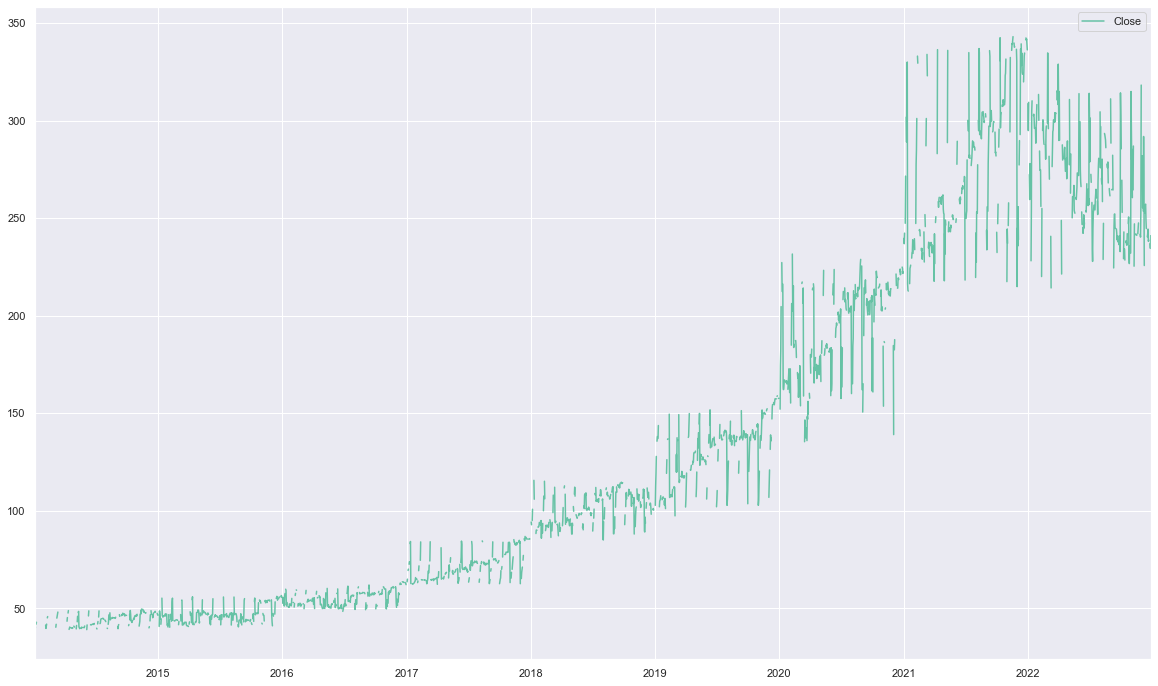

In [20]:
plot = df.head(3619).plot(figsize=(20, 12))

# forward fill

In [21]:
df["ffilled"] = df["Close"].ffill()
df.head(12)

,Close,ffilled
2014-01-04,41.419998,41.419998
2014-01-05,40.000000,40.000000
2014-01-06,NaN,40.000000
2014-01-07,41.869999,41.869999
2014-01-08,42.860001,42.860001
2014-01-09,NaN,42.860001
2014-01-10,45.900002,45.900002
2014-01-11,NaN,45.900002
2014-01-12,48.619999,48.619999
2014-01-13,NaN,48.619999


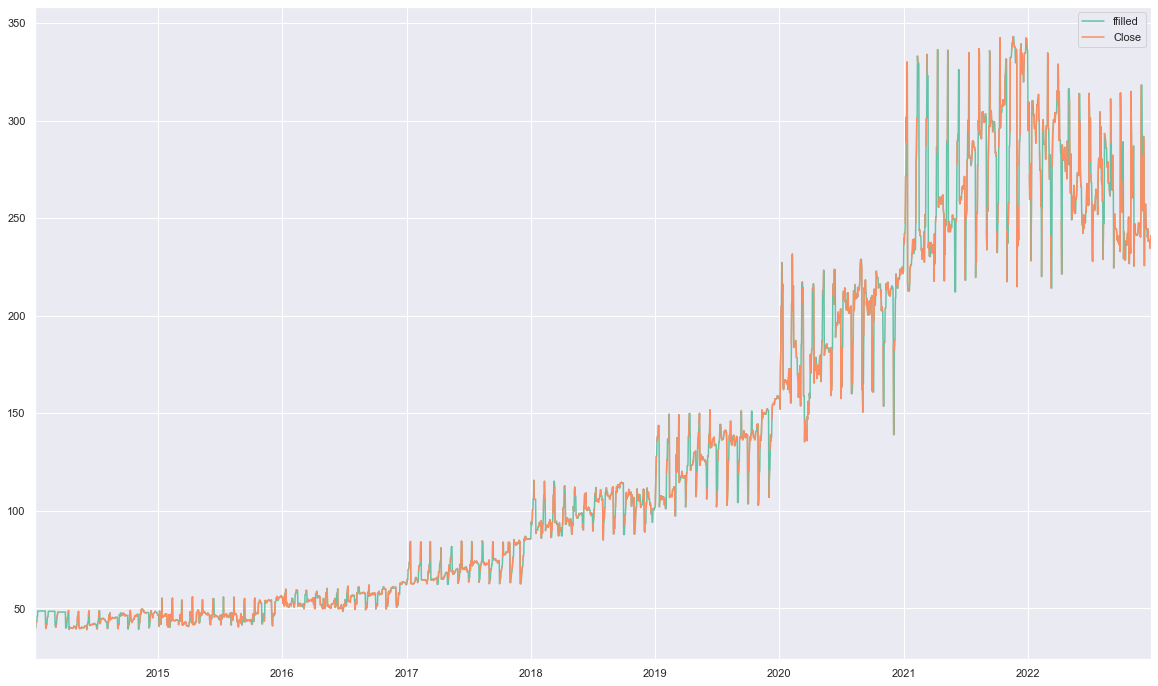

In [22]:
df = df[["ffilled", "Close"]]
plot = df.head(3619).plot(figsize=(20, 12))

In [23]:
df.ffilled

2014-01-04     41.419998
2014-01-05     40.000000
2014-01-06     40.000000
2014-01-07     41.869999
2014-01-08     42.860001
                 ...    
2022-12-26    238.729996
2022-12-27    236.960007
2022-12-28    234.529999
2022-12-29    241.009995
2022-12-30    239.820007
Freq: D, Name: ffilled, Length: 3283, dtype: float64

In [24]:
df.rename(columns={"ffilled": "close"}, inplace=True)
df

,close,Close
2014-01-04,41.419998,41.419998
2014-01-05,40.000000,40.000000
2014-01-06,40.000000,NaN
2014-01-07,41.869999,41.869999
2014-01-08,42.860001,42.860001
...,...,...
2022-12-26,238.729996,NaN
2022-12-27,236.960007,236.960007
2022-12-28,234.529999,234.529999
2022-12-29,241.009995,241.009995


In [25]:
df.drop(["Close"],axis=1,inplace=True)

In [26]:
df

,close
2014-01-04,41.419998
2014-01-05,40.000000
2014-01-06,40.000000
2014-01-07,41.869999
2014-01-08,42.860001
...,...
2022-12-26,238.729996
2022-12-27,236.960007
2022-12-28,234.529999
2022-12-29,241.009995


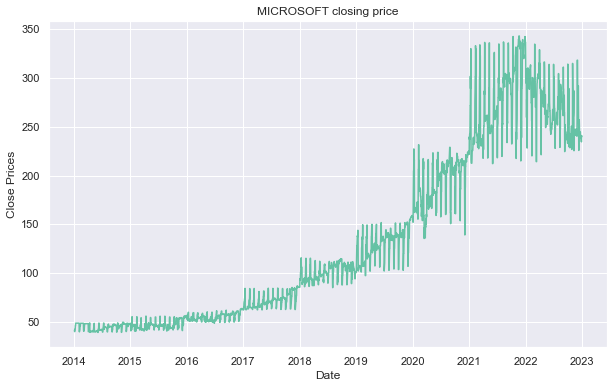

In [27]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(df['close'])
plt.title('MICROSOFT closing price')
plt.show()

# Checking stationarity of the data

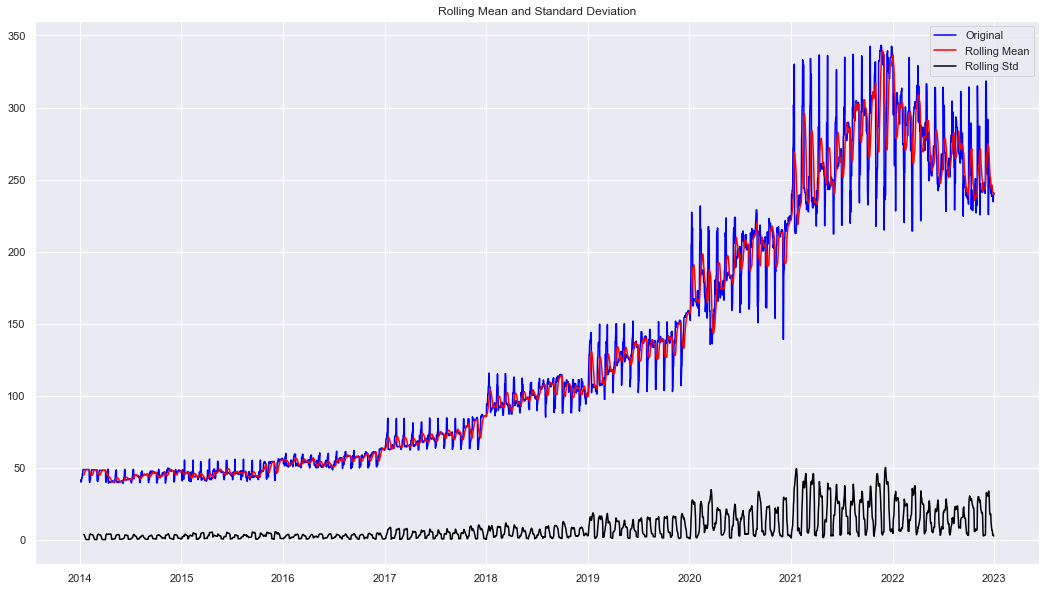

Results of dickey fuller test
Test Statistics                   0.438566
p-value                           0.982881
No. of lags used                 29.000000
Number of observations used    3253.000000
critical value (1%)              -3.432362
critical value (5%)              -2.862429
critical value (10%)             -2.567243
dtype: float64


In [28]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    
    plt.figure(figsize=(18, 10))

    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df.close)

## Differencing

In [29]:
diff_df=df.diff()
diff_df

,close
2014-01-04,NaN
2014-01-05,-1.419998
2014-01-06,0.000000
2014-01-07,1.869999
2014-01-08,0.990002
...,...
2022-12-26,0.000000
2022-12-27,-1.769989
2022-12-28,-2.430008
2022-12-29,6.479996


 # TRAIN TEST SPLIT

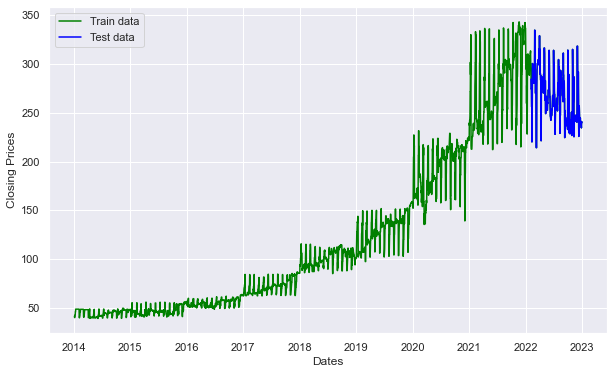

In [30]:
#split data into train and training set
train_data, test_data = df[3:int(len(df)*0.9)], df[int(len(df)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

# AUTO ARIMA

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=21482.647, Time=0.29 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=21468.937, Time=0.28 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=21467.055, Time=0.75 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=21480.913, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=21249.339, Time=3.64 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=21458.698, Time=2.30 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=21458.777, Time=2.98 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=21461.338, Time=1.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=21460.568, Time=0.75 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=21460.125, Time=4.20 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=21265.411, Time=1.04 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 17.396 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:      

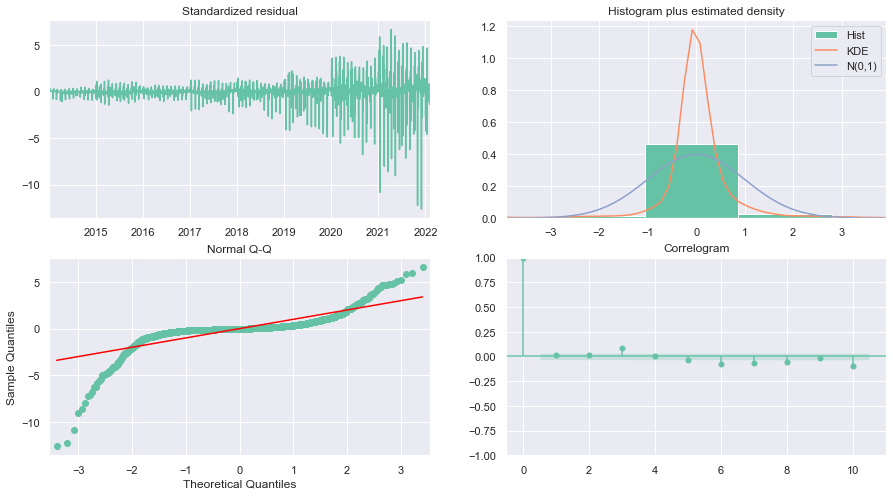

In [31]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=1,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

#  Build the model

In [32]:

from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train_data, order=(1,1,1))

fitted=model.fit()

model_summary = fitted.summary()
print(model_summary)

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 2951
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -10629.706
Date:                Sun, 24 Sep 2023   AIC                          21265.411
Time:                        23:16:10   BIC                          21283.380
Sample:                    01-07-2014   HQIC                         21271.880
                         - 02-04-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8087      0.008     95.780      0.000       0.792       0.825
ma.L1         -0.9724      0.004   -231.847      0.000      -0.981      -0.964
sigma2        78.9136      0.618    127.722      0.0

# Forecasting on test dadaset

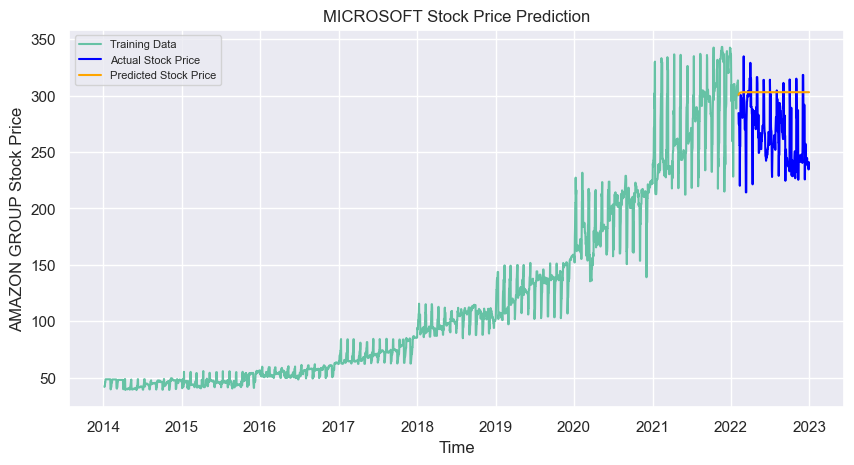

In [38]:
# Forecast
forecast_steps = 329 # Adjust this to your desired number of forecasted time steps
forecast_values = fitted.forecast(steps=forecast_steps)  # Forecast values

# Make as pandas series
fc_series = pd.Series(forecast_values, index=test_data.index)  # Use the appropriate index

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='Training Data')
plt.plot(test_data, color='blue', label='Actual Stock Price')
plt.plot(fc_series, color='orange', label='Predicted Stock Price')
plt.title('MICROSOFT Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('AMAZON GROUP Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

##  Evaluating Forecast results

In [39]:
# report performance
mse = mean_squared_error(test_data, forecast_values)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, forecast_values)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, forecast_values))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(forecast_values - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 1940.9546701712386
MAE: 38.090870364969525
RMSE: 44.05626709301684
MAPE: 2022-02-05 00:00:00   NaN
2022-02-06 00:00:00   NaN
2022-02-07 00:00:00   NaN
2022-02-08 00:00:00   NaN
2022-02-09 00:00:00   NaN
                       ..
2022-12-27 00:00:00   NaN
2022-12-28 00:00:00   NaN
2022-12-29 00:00:00   NaN
2022-12-30 00:00:00   NaN
close                 NaN
Length: 330, dtype: float64
